Tuesday, June 13, 2023

This video shows how to manually implement back propogation in a multi layer perceptron.

docker container start sad_nightingale

[Building makemore Part 4: Becoming a Backprop Ninja](https://www.youtube.com/watch?v=q8SA3rM6ckI)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
lenOfWords = len(words)
print(lenOfWords)
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))

In [4]:
delimiter = '.'

In [5]:
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi[delimiter] = 0

In [6]:
itos = { c:i for i, c in stoi.items()}

In [7]:
vocab_size = len(itos)
print(vocab_size)

27


In [8]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + delimiter:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [9]:
thgttg = 42
manualSeed = 2147483647

In [10]:
import random
random.seed(thgttg)
random.shuffle(words)

In [11]:
n1 = int(0.8 * lenOfWords)
n2 = int(0.9 * lenOfWords)
print(n1, n2)

25626 28829


In [12]:
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Ytd = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [13]:
# ok boilerplate code is done, now we get to the action ...

In [14]:
torch.all??

Docstring:
all(input) -> Tensor

Tests if all elements in :attr:`input` evaluate to `True`.

.. note:: This function matches the behaviour of NumPy in returning
          output of dtype `bool` for all supported dtypes except `uint8`.
          For `uint8` the dtype of output is `uint8` itself.

Example::

    >>> a = torch.rand(1, 2).bool()
    >>> a
    tensor([[False, True]], dtype=torch.bool)
    >>> torch.all(a)
    tensor(False, dtype=torch.bool)
    >>> a = torch.arange(0, 3)
    >>> a
    tensor([0, 1, 2])
    >>> torch.all(a)
    tensor(False)

.. function:: all(input, dim, keepdim=False, *, out=None) -> Tensor
   :noindex:

For each row of :attr:`input` in the given dimension :attr:`dim`,
returns `True` if all elements in the row evaluate to `True` and `False` otherwise.

If :attr:`keepdim` is ``True``, the output tensor is of the same size
as :attr:`input` except in the dimension :attr:`dim` where it is of size 1.
Otherwise, :attr:`dim` is squeezed (see :func:`torch.squeeze`

In [15]:
torch.allclose??

Docstring:
allclose(input, other, rtol=1e-05, atol=1e-08, equal_nan=False) -> bool

This function checks if all :attr:`input` and :attr:`other` satisfy the condition:

.. math::
    \lvert \text{input} - \text{other} \rvert \leq \texttt{atol} + \texttt{rtol} \times \lvert \text{other} \rvert

elementwise, for all elements of :attr:`input` and :attr:`other`. The behaviour of this function is analogous to
`numpy.allclose <https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html>`_

Args:
    input (Tensor): first tensor to compare
    other (Tensor): second tensor to compare
    atol (float, optional): absolute tolerance. Default: 1e-08
    rtol (float, optional): relative tolerance. Default: 1e-05
    equal_nan (bool, optional): if ``True``, then two ``NaN`` s will be considered equal. Default: ``False``

Example::

    >>> torch.allclose(torch.tensor([10000., 1e-07]), torch.tensor([10000.1, 1e-08]))
    False
    >>> torch.allclose(torch.tensor([10000., 1e-08]), torch.t

In [16]:
# utility function we weill use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate {str(app):5s} | maxdiff {maxdiff}')

In [17]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducability

# the embedding table for the characters ...
C = torch.randn((vocab_size, n_embd), generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/ ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # using b1 just for fun, it's useless because of batch normalization

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# Note: I am initializing many of these parameters in non-standard ways
# because sometimes initializing with e.g. all zeros could mask an incorrect
# implementation of the backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True



4137


In [18]:
batch_size = 32
n = batch_size # a sorter variable, also for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [19]:
# Xb.sum??
# Docstring:
# sum(dim=None, keepdim=False, dtype=None) -> Tensor

# See :func:`torch.sum`
# Type:      builtin_function_or_method

In [20]:
3 * 2 + 7

13

In [21]:
# Xb.max??
# Docstring:
# max(dim=None, keepdim=False) -> Tensor or (Tensor, Tensor)

# See :func:`torch.max`
# Type:      builtin_function_or_method

In [22]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear Layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# Batch Normalization Layer
bnmeani = 1/n * hprebn.sum(dim=0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * (bndiff2).sum(dim=0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-Linearity
h = torch.tanh(hpreact)

# Linear Layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(dim=1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(dim=1, keepdim=True)
counts_sum_inv = counts_sum**-1 # if we use (1.0 / counts_sum) instead then we can't get backprop to be bit exact ... 
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
    
# PyTorch retain_grad => Enables this Tensor to have their grad populated during backward(). 
# This is a no-op for leaf tensors

# afaik there is no cleaner way to do this ...
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, 
    norm_logits, logit_maxes, logits, h, hpreact, bnraw,
    bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
    embcat, emb]:
    t.retain_grad()
    
loss.backward()
loss



tensor(3.3506, grad_fn=<NegBackward0>)

### Exercise 1:

Backprop through the whole thing manually, backpropagating through exactly all of the variables
as they are defined in the forward pass above, one by one.

#### loss = -logprobs[range(n), Yb].mean()

In [23]:
print(n)
print(logprobs[range(n), Yb].shape)
print(logprobs.shape)
print(Yb.shape)
print(loss)

32
torch.Size([32])
torch.Size([32, 27])
torch.Size([32])
tensor(3.3506, grad_fn=<NegBackward0>)


In [24]:
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [25]:
someIndex = 19
print(Yb[someIndex].item())
print(logprobs[someIndex])
print(logprobs[someIndex, Yb[someIndex]])

9
tensor([-3.8296, -3.9040, -3.3930, -4.0638, -3.3491, -3.3621, -2.7999, -3.0062,
        -3.2712, -3.4587, -3.4206, -3.1892, -2.6664, -2.7882, -4.1324, -3.7658,
        -3.6180, -3.9333, -3.5323, -2.3856, -3.1179, -3.4208, -3.1290, -3.0689,
        -3.4257, -3.7739, -3.7573], grad_fn=<SelectBackward0>)
tensor(-3.4587, grad_fn=<SelectBackward0>)


dlogprobs will hold the derivative of the loss with respect to all the elements of logprobs. For this reason, it will also have the same shape as logprobs.

Now how does logprobs influence the loss? Remember Yb is just an array of all the correct indices of the next character.  

loss = -(a + b + c) / 3

loss = -a/3 - b/3 - c/3

So what is the derivative of the loss with respect to a?

dloss/da = -1/3

So the derivative is 1/n where n is the number of digits.

In [26]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs.shape

torch.Size([32, 27])

In [27]:
dlogprobs[range(n), Yb] = -1.0/n

In [28]:
1.0 / n

0.03125

In [29]:
dlogprobs[someIndex]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000])

In [30]:
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate True  | maxdiff 0.0


#### logprobs = probs.log()

![](images/dxlogx.png)

In our example, x is probs, so the local derivate of probs.log() is simply (1.0 / probs).

And because of the chain rule, we multiply that by dlogprobs:

In [31]:
dprobs = (1.0 / probs) * dlogprobs

In [32]:
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate True  | maxdiff 0.0


#### probs = counts * counts_sum_inv

In [33]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [34]:
# c = a * b, but with tensors:
# a[3x3] * b[3x1] --->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b3
# a31*b3 a32*b3 a33*b3
# c[3x3]

In [35]:
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)

In [36]:
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate True  | maxdiff 0.0


In [37]:
dcounts = (counts_sum_inv * dprobs)

#### counts_sum_inv = counts_sum**-1 

![](images/ddx1_x.png)

In [38]:
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

In [39]:
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate True  | maxdiff 0.0


#### counts_sum = counts.sum(dim=1, keepdim=True)

In [40]:
# we need to add in the previous value we calculated for dcounts ... so use += 
dcounts += torch.ones_like(counts) * dcounts_sum

In [41]:
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate True  | maxdiff 0.0


#### counts = norm_logits.exp()

![](images/ddx_ex.png)

The derivate of norm_logits.exp() is norm_logits.exp() which is already in counts, so let's just use counts.

In [42]:
dnorm_logits = counts * dcounts

In [43]:
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate True  | maxdiff 0.0


#### norm_logits = logits - logit_maxes

In [44]:
# shapes are different ...
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [45]:
# c11 c12 c13 = a11 a12 a13 - b1
# c21 c22 c23 = a21 a22 a23 - b2
# c31 c32 c33 = a31 a32 a33 - b3

# so e.g. c32 = a32 - b3

In [46]:
dlogits = dnorm_logits.clone() # this is NOT our final derivative for dlogits!
dlogit_maxes = (-dnorm_logits).sum(dim=1, keepdim=True)

In [47]:
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate True  | maxdiff 0.0


#### logit_maxes = logits.max(dim=1, keepdim=True).values

In [48]:
# notice we use += because we need to add in the previous value
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

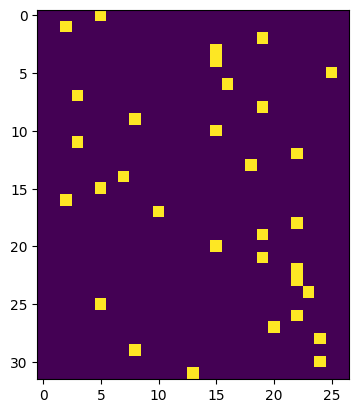

In [49]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [50]:
cmp('logits',dlogits,logits)

logits          | exact: True  | approximate True  | maxdiff 0.0


#### logits = h @ W2 + b2 

In [51]:
print(f'dlogits.shape => {dlogits.shape}')
print(f'h.shape =======> {h.shape}')
print(f'W2.shape ======> {W2.shape}')
print(f'(h@W2).shape ==> {(h@W2).shape}')
print(f'b2.shape ======> {b2.shape}')

dlogits.shape => torch.Size([32, 27])
h.shape =======> torch.Size([32, 64])
W2.shape ======> torch.Size([64, 27])
(h@W2).shape ==> torch.Size([32, 27])
b2.shape ======> torch.Size([27])


In [52]:
# dh must have the same shape as h 32x64
dh = dlogits @ W2.T

In [53]:
# dW2 must have the same shape as W2 64x27
dW2 = h.T @ dlogits

In [54]:
# db2 must have the same shape as b2 27
db2 = dlogits.sum(dim=0)

In [55]:
cmp('h',dh,h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

h               | exact: True  | approximate True  | maxdiff 0.0
W2              | exact: True  | approximate True  | maxdiff 0.0
b2              | exact: True  | approximate True  | maxdiff 0.0


#### h = torch.tanh(hpreact)

![](images/ddx_tanh.png)

Notice the derivate of tanh(z) is 1 - a**2, where a is the output of tanh, not the input.

In [56]:
# remember, the chain rule ... so multiply by dh
dhpreact = (1.0 - h**2) * dh

In [57]:
# I think this is not exact just due to some rounding differences ... 
cmp('hpreact', dhpreact, hpreact)

# We get this result ALMOST every time we restart the kernel and run all ...
# hpreact         | exact: False | approximate True  | maxdiff 4.656612873077393e-10

# hmm other times we can get this ..
# hpreact         | exact: False | approximate True  | maxdiff 9.313225746154785e-10

hpreact         | exact: False | approximate True  | maxdiff 4.656612873077393e-10


In [58]:
torch.all(dhpreact == hpreact.grad).item()

False

In [59]:
torch.allclose(dhpreact, hpreact.grad)

True

In [60]:
(dhpreact - hpreact.grad).abs().max().item()

4.656612873077393e-10

In [61]:
(dhpreact - hpreact.grad)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.1642e-10,  0.0000e+00],
        [ 5.8208e-11,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  2.9104e-11,  ...,  0.0000e+00,
         -2.9104e-11,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          5.8208e-11, -1.1642e-10],
        [-7.2760e-12,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          2.9104e-11,  0.0000e+00]], grad_fn=<SubBackward0>)

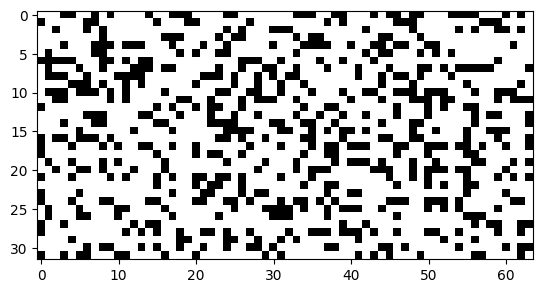

In [82]:
not_equal = torch.not_equal(dhpreact, hpreact.grad)
plt.imshow(not_equal, cmap='binary')
plt.show()
# white cells are equal ... why do we not see all white cells?

#### hpreact = bngain * bnraw + bnbias